In [1]:
import os
os.chdir("/oak/stanford/groups/akundaje/kobbad/UCE")
from model import *
import scanpy as sc
from tqdm.auto import tqdm
from torch import nn, Tensor
from evaluate import get_ESM2_embeddings
from utils import get_ESM2_embeddings_x
import argparse
from accelerate import Accelerator
from evaluate import AnndataProcessor
from eval_data import MultiDatasetSentences, MultiDatasetSentenceCollator
import pickle
from torch.utils.data import DataLoader
import torch
import numpy as np
import pickle
import pandas as pd

In [2]:
parser = argparse.ArgumentParser(
    description='Embed a single anndata using UCE.')

# Anndata Processing Arguments
parser.add_argument('--adata_path', type=str,
                    default=None,
                    help='Full path to the anndata you want to embed.')
parser.add_argument('--dir', type=str,
                    default="./",
                    help='Working folder where all files will be saved.')
parser.add_argument('--species', type=str, default="human",
                    help='Species of the anndata.')
parser.add_argument('--filter', type=bool, default=True,
                    help='Additional gene/cell filtering on the anndata.')
parser.add_argument('--skip', type=bool, default=True,
                    help='Skip datasets that appear to have already been created.')

# Model Arguments
parser.add_argument('--model_loc', type=str,
                    default=None,
                    help='Location of the model.')
parser.add_argument('--batch_size', type=int, default=25,
                    help='Batch size.')
parser.add_argument('--pad_length', type=int, default=1536,
                    help='Batch size.')
parser.add_argument("--pad_token_idx", type=int, default=0,
                    help="PAD token index")
parser.add_argument("--chrom_token_left_idx", type=int, default=1,
                    help="Chrom token left index")
parser.add_argument("--chrom_token_right_idx", type=int, default=2,
                    help="Chrom token right index")
parser.add_argument("--cls_token_idx", type=int, default=3,
                    help="CLS token index")
parser.add_argument("--CHROM_TOKEN_OFFSET", type=int, default=143574,
                    help="Offset index, tokens after this mark are chromosome identifiers")
parser.add_argument('--sample_size', type=int, default=1024,
                    help='Number of genes sampled for cell sentence')
parser.add_argument('--CXG', type=bool, default=True,
                    help='Use CXG model.')
parser.add_argument('--nlayers', type=int, default=4,
                    help='Number of transformer layers.')
parser.add_argument('--output_dim', type=int, default=1280,
                    help='Output dimension.')
parser.add_argument('--d_hid', type=int, default=5120,
                    help='Hidden dimension.')
parser.add_argument('--token_dim', type=int, default=5120,
                    help='Token dimension.')
parser.add_argument('--multi_gpu', type=bool, default=False,
                    help='Use multiple GPUs')

# Misc Arguments
parser.add_argument("--spec_chrom_csv_path",
                    default="./model_files/species_chrom.csv", type=str,
                    help="CSV Path for species genes to chromosomes and start locations.")
parser.add_argument("--token_file",
                    default="./model_files/all_tokens.torch", type=str,
                    help="Path for token embeddings.")
parser.add_argument("--protein_embeddings_dir",
                    default="./model_files/protein_embeddings/", type=str,
                    help="Directory where protein embedding .pt files are stored.")
parser.add_argument("--offset_pkl_path",
                    default="./model_files/species_offsets.pkl", type=str,
                        help="PKL file which contains offsets for each species.")

# masking arguments
parser.add_argument("--genes_to_mask", 
                    nargs='+',
                    default= None,
                    type=str,
                    help="List of genes to mask")

parser.add_argument("--genes_to_pe_idx",
                    default="./model_files/gene_to_pe_index.pkl",type=str,
                    help="Path to gene to protein embedding index mapping")

_StoreAction(option_strings=['--genes_to_pe_idx'], dest='genes_to_pe_idx', nargs=None, const=None, default='./model_files/gene_to_pe_index.pkl', type=<class 'str'>, choices=None, help='Path to gene to protein embedding index mapping', metavar=None)

In [3]:
args = parser.parse_args()

In [4]:
args.model_loc = "/oak/stanford/groups/akundaje/kobbad/UCE/model_files/4layer_model.torch"

In [5]:
#### Set up the model ####
token_dim = args.token_dim
emsize = 1280  # embedding dimension
d_hid = args.d_hid  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = args.nlayers  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 20  # number of heads in nn.MultiheadAttention
dropout = 0.05  # dropout probability
model = TransformerModel(token_dim=token_dim, d_model=emsize, nhead=nhead,
                            d_hid=d_hid,
                            nlayers=nlayers, dropout=dropout,
                            output_dim=args.output_dim)

In [6]:
# intialize as empty
empty_pe = torch.zeros(145469, 5120)
empty_pe.requires_grad = False
model.pe_embedding = nn.Embedding.from_pretrained(empty_pe)
model.load_state_dict(torch.load(args.model_loc, map_location="cpu"),
                        strict=True)
# Load in the real token embeddings
all_pe = get_ESM2_embeddings(args)

In [7]:
if all_pe.shape[0] != 145469: 
        all_pe.requires_grad = False
        model.pe_embedding = nn.Embedding.from_pretrained(all_pe)

In [8]:
model = model.eval()
accelerator = Accelerator(project_dir=args.dir)
model = accelerator.prepare(model)
batch_size = args.batch_size

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
ann_object = "10k_pbmcs_proc_uce_adata.h5ad"

spi1_ko_adata = f"./SPI1_KO/{ann_object}"
stat2_ko_adata = f"./STAT2_KO/{ann_object}"
stat2_isg15_ko_adata = f"./STAT2_ISG15_KO/{ann_object}"
fos_ko_adata = f"./FOS_KO/{ann_object}"

In [21]:
spi1_ko_adata = sc.read(spi1_ko_adata)
stat2_ko_adata = sc.read(stat2_ko_adata)
stat2_isg15_ko_adata = sc.read(stat2_isg15_ko_adata)
fod_ko_adata = sc.read(fos_ko_adata)
control_adata = sc.read("10k_pbmcs_proc_uce_adata.h5ad")



In [11]:
# these are the cell embeddings 
stat2_ko_adata.obsm['X_uce']

array([[ 3.4580035e-03, -2.3529574e-02, -3.1182794e-02, ...,
        -8.0126669e-04,  2.1853451e-02, -6.1218746e-02],
       [ 2.3518290e-02, -3.1451914e-02, -1.5527843e-03, ...,
        -1.9831159e-05,  7.7214935e-03, -3.6870152e-02],
       [ 2.1272138e-02, -5.7123741e-03, -9.9359388e-03, ...,
        -9.8184915e-03,  3.0129295e-02, -9.4538536e-03],
       ...,
       [ 1.0827974e-02,  1.1530056e-02, -2.9507408e-02, ...,
        -3.1399436e-04, -3.2667364e-03, -5.3507641e-02],
       [ 2.4108812e-03, -6.4325400e-02,  3.3457559e-02, ...,
         5.7656444e-03,  2.6347797e-02, -5.7232667e-02],
       [ 1.8112633e-02, -8.6961975e-03,  1.6486976e-02, ...,
         1.0617969e-02,  2.7339006e-02,  1.3155853e-03]], dtype=float32)

In [12]:
# read in the gene to protein embedding index mapping
with open(args.genes_to_pe_idx, 'rb') as f:
    gene_to_pe_idx = pickle.load(f)

In [13]:
model.pe_embedding(torch.tensor(gene_to_pe_idx["STAT2"]).to('cuda'))

tensor([ 0.1137,  0.0827,  0.1744,  ..., -0.0165,  0.0019, -0.1174],
       device='cuda:0')

In [14]:
statko_cell_embeddings = torch.Tensor(stat2_ko_adata.obsm['X_uce']).to('cuda')
control_cell_embeddings = torch.Tensor(control_adata.obsm['X_uce']).to('cuda')

statko_cell_embeddings.shape, control_cell_embeddings.shape

(torch.Size([11990, 1280]), torch.Size([11990, 1280]))

In [15]:
STAT2_gene_embedding = all_pe[torch.tensor(gene_to_pe_idx["STAT2"]).to('cuda')].to('cuda')

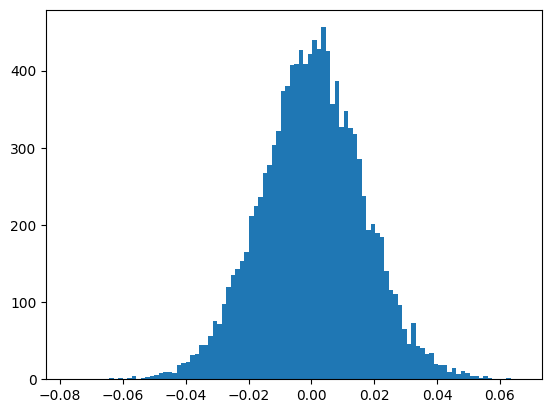

In [50]:
import matplotlib.pyplot as plt

plt.hist(np.array(logits_STAT2_expression_control) - np.array(logits_STAT2_expression_ko), bins=100);

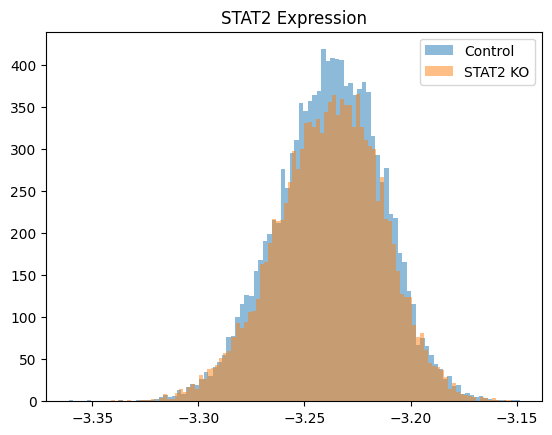

In [76]:
plt.hist(np.array(logits_STAT2_expression_control), bins=100, alpha=0.5, label="Control");
plt.hist(np.array(logits_STAT2_expression_ko), bins=100, alpha=0.5, label="STAT2 KO");
plt.title("STAT2 Expression");
plt.legend();

plt.show()

In [97]:
len(gene_to_pe_idx.keys())

10809

In [51]:
ISG15_gene_embedding = all_pe[torch.tensor(gene_to_pe_idx["ISG15"]).to('cuda')].to('cuda')

In [52]:
logits_ISG15_expression_ko = []
logits_ISG15_expression_control = []


for i in tqdm(range(0, statko_cell_embeddings.shape[0])):
    logits_ISG15_expression_ko.append(model.predict(statko_cell_embeddings[i], ISG15_gene_embedding).detach().cpu().numpy()[0])
    logits_ISG15_expression_control.append(model.predict(control_cell_embeddings[i], ISG15_gene_embedding).detach().cpu().numpy()[0])


100%|██████████| 11990/11990 [00:09<00:00, 1286.67it/s]


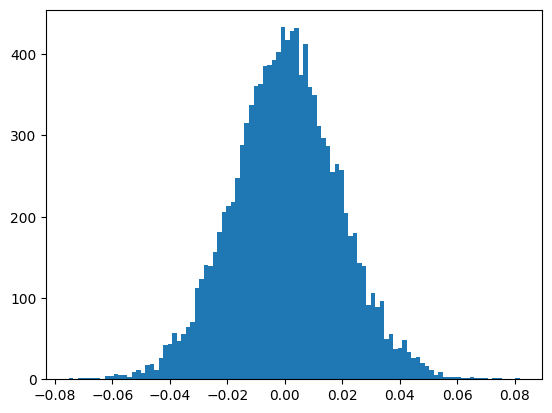

In [53]:
import matplotlib.pyplot as plt

plt.hist(np.array(logits_ISG15_expression_control) - np.array(logits_ISG15_expression_ko), bins=100);

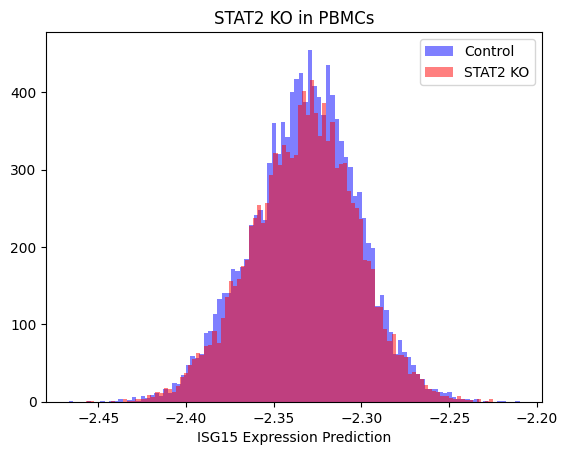

In [59]:
plt.hist(np.array(logits_ISG15_expression_control), bins=100, color="blue", alpha=0.5, label="Control");
plt.hist(np.array(logits_ISG15_expression_ko), bins=100, color="red", alpha=0.5, label="STAT2 KO");
plt.xlabel("ISG15 Expression Prediction");
plt.title("STAT2 KO in PBMCs");
plt.legend();


Trying inference using the same embeddings twice in case the difference is noise

In [73]:
logits_ISG15_expression_control_rep1 = []
logits_ISG15_expression_control_rep2 = []


for i in tqdm(range(0, statko_cell_embeddings.shape[0])):
    logits_ISG15_expression_control_rep1.append(model.predict(control_cell_embeddings[i], ISG15_gene_embedding).detach().cpu().numpy()[0])
    logits_ISG15_expression_control_rep2.append(model.predict(control_cell_embeddings[i], ISG15_gene_embedding).detach().cpu().numpy()[0])


100%|██████████| 11990/11990 [00:09<00:00, 1252.16it/s]


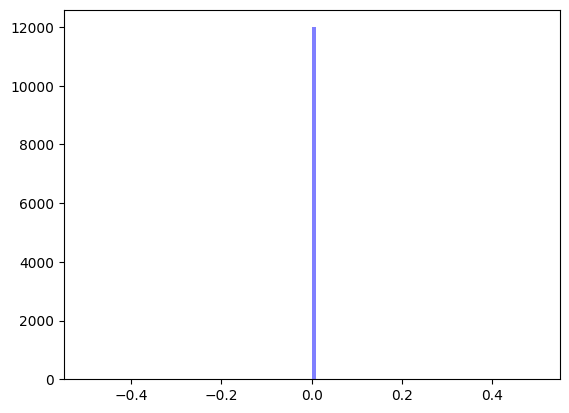

In [75]:
plt.hist(np.array(logits_ISG15_expression_control_rep1) - np.array(logits_ISG15_expression_control_rep2), bins=100, color="blue", alpha=0.5, label="Control Rep 1");



Maybe, I need to look at cell type specific transcription factors for cell types and see if the model learns a correlation? 

In [18]:
# Convert the data in control_adata.X to a DataFrame
counts_data = pd.DataFrame(control_adata.X.toarray() if hasattr(control_adata.X, "toarray") else control_adata.X, 
                  index=control_adata.obs['cell_type'], 
                  columns=control_adata.var['gene_symbols'])

# Display the resulting DataFrame
counts_data.head()

gene_symbols,SAMD11,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,TNFRSF18,TNFRSF4,SDF4,...,S100B,PRMT2,MT-ND1,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND4,MT-ND6
cell_type,,,,,,,,,,,,,,,,,,,,,
CD4 T cells,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,7.0,15.0,9.0,0.0,1.0,14.0,8.0,0.0
CD4 T cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,3.0,6.0,0.0,3.0,6.0,4.0,1.0
CD14+ Monocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,7.0,37.0,25.0,0.0,10.0,23.0,19.0,0.0
CD14+ Monocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,6.0,48.0,25.0,0.0,16.0,22.0,15.0,0.0
CD8 T cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,19.0,16.0,0.0,10.0,13.0,17.0,0.0


In [19]:
counts_data_rank = counts_data.rank(axis=1, pct=True)

In [20]:
counts_data_rank.head()

gene_symbols,SAMD11,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,TNFRSF18,TNFRSF4,SDF4,...,S100B,PRMT2,MT-ND1,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND4,MT-ND6
cell_type,,,,,,,,,,,,,,,,,,,,,
CD4 T cells,0.466047,0.466047,0.466047,0.959710,0.466047,0.466047,0.466047,0.466047,0.995559,0.466047,...,0.466047,0.959710,0.997317,0.998520,0.997780,0.466047,0.959710,0.998242,0.997595,0.466047
CD4 T cells,0.479277,0.479277,0.479277,0.479277,0.479277,0.479277,0.479277,0.479277,0.479277,0.975900,...,0.479277,0.479277,0.997502,0.996623,0.998381,0.479277,0.996623,0.998381,0.997502,0.975900
CD14+ Monocytes,0.456471,0.456471,0.456471,0.456471,0.456471,0.456471,0.456471,0.456471,0.456471,0.456471,...,0.456471,0.944491,0.995559,0.999306,0.998705,0.456471,0.996947,0.998520,0.998057,0.456471
CD14+ Monocytes,0.457304,0.457304,0.457304,0.457304,0.457304,0.457304,0.457304,0.457304,0.457304,0.945462,...,0.457304,0.457304,0.995606,0.999445,0.998659,0.457304,0.997780,0.998288,0.997456,0.457304
CD8 T cells,0.468082,0.468082,0.468082,0.468082,0.468082,0.468082,0.468082,0.468082,0.468082,0.468082,...,0.468082,0.468082,0.997595,0.999722,0.999214,0.468082,0.998057,0.998566,0.999491,0.468082


run analysis on all the genes and produce logits and then softmax

In [23]:
gene_emb_indices =[gene_to_pe_idx[gene] for gene in control_adata.var['gene_symbols']]

In [24]:
embeddings = model.pe_embedding(torch.tensor(gene_emb_indices).to('cuda'))

model.gene_embedding_layer(embeddings).shape

torch.Size([10809, 1280])

In [25]:
embeddings.shape

torch.Size([10809, 5120])

In [22]:
control_embeddings = torch.tensor(control_adata.obsm['X_uce']).to('cuda')
stat2_ko_embeddings = torch.tensor(stat2_ko_adata.obsm['X_uce']).to('cuda')
stat2_isg15_ko_embeddings = torch.tensor(stat2_isg15_ko_adata.obsm['X_uce']).to('cuda')
fos_ko_embeddings = torch.tensor(fod_ko_adata.obsm['X_uce']).to('cuda')

In [26]:
batch_size =25

results_control = []
results_stat2_ko = []
results_stat2_isg15_ko = []
results_fos_ko = []

for i in tqdm(range(0, control_embeddings.shape[0], batch_size)):

    cell_embedding_batch_control = control_embeddings[i:i+batch_size]
    cell_embedding_batch_stat2_ko = stat2_ko_embeddings[i:i+batch_size]
    cell_embedding_batch_stat2_isg15_ko = stat2_isg15_ko_embeddings[i:i+batch_size]
    cell_embedding_batch_fos_ko = fos_ko_embeddings[i:i+batch_size]

    dec_control = model.predict(cell_embedding_batch_control, embeddings)
    dec_stat2_ko = model.predict(cell_embedding_batch_stat2_ko, embeddings)
    dec_stat2_isg15_ko = model.predict(cell_embedding_batch_stat2_isg15_ko, embeddings)
    dec_fos_ko = model.predict(cell_embedding_batch_fos_ko, embeddings)

    results_control.append(dec_control.detach().cpu())
    results_stat2_ko.append(dec_stat2_ko.detach().cpu())
    results_stat2_isg15_ko.append(dec_stat2_isg15_ko.detach().cpu())
    results_fos_ko.append(dec_fos_ko.detach().cpu())


100%|██████████| 480/480 [07:20<00:00,  1.09it/s]


In [27]:
results_control_torch = torch.tensor(np.concatenate(results_control)).squeeze()
results_stat2_ko_torch = torch.tensor(np.concatenate(results_stat2_ko)).squeeze()
results_stat2_isg15_ko_torch = torch.tensor(np.concatenate(results_stat2_isg15_ko)).squeeze()
results_fos_ko_torch = torch.tensor(np.concatenate(results_fos_ko)).squeeze()

In [28]:
probs_control = torch.nn.functional.softmax(results_control_torch, dim=1)
probs_stat2_ko = torch.nn.functional.softmax(results_stat2_ko_torch, dim=1)
probs_stat2_isg15_ko = torch.nn.functional.softmax(results_stat2_isg15_ko_torch, dim=1)
probs_fos_ko = torch.nn.functional.softmax(results_fos_ko_torch, dim=1)

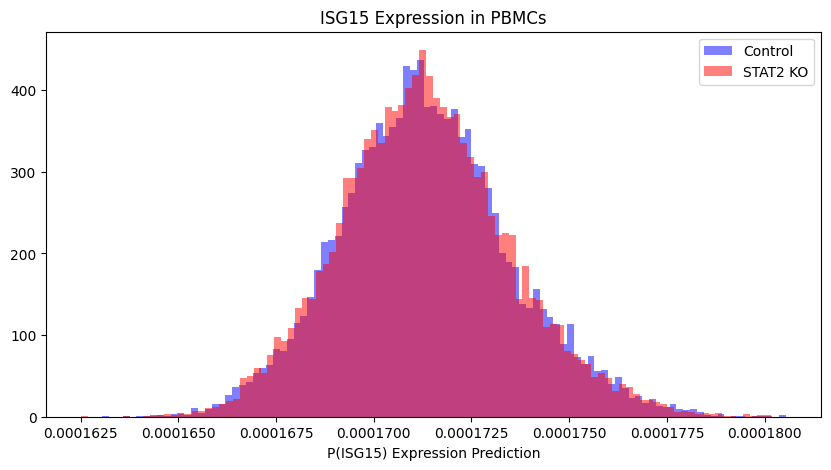

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(probs_control[:,3].detach().cpu().numpy(), bins=100, color="blue", alpha=0.5, label="Control");
ax.hist(probs_stat2_ko[:,3].detach().cpu().numpy(), bins=100, color="red", alpha=0.5, label="STAT2 KO");

ax.title.set_text("ISG15 Expression in PBMCs");
ax.legend();

ax.set_xlabel("P(ISG15) Expression Prediction");

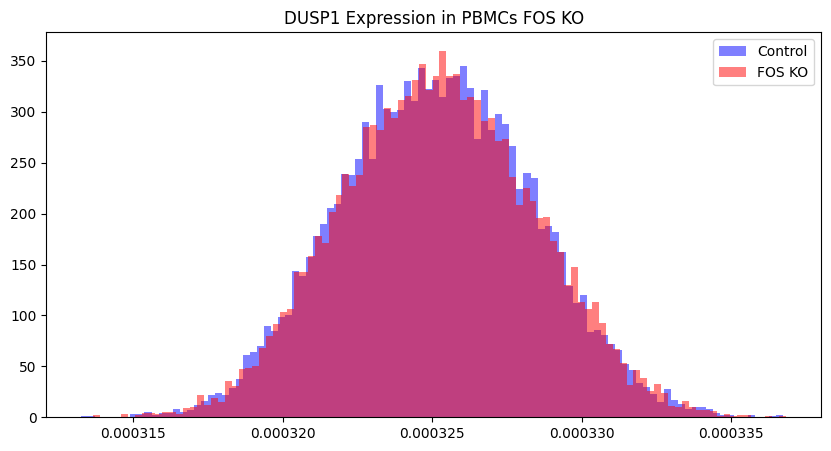

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(probs_control[:,3214].detach().cpu().numpy(), bins=100, color="blue", alpha=0.5, label="Control");
ax.hist(probs_fos_ko[:,3214].detach().cpu().numpy(), bins=100, color="red", alpha=0.5, label="FOS KO");

ax.title.set_text("DUSP1 Expression in PBMCs FOS KO");
ax.legend();

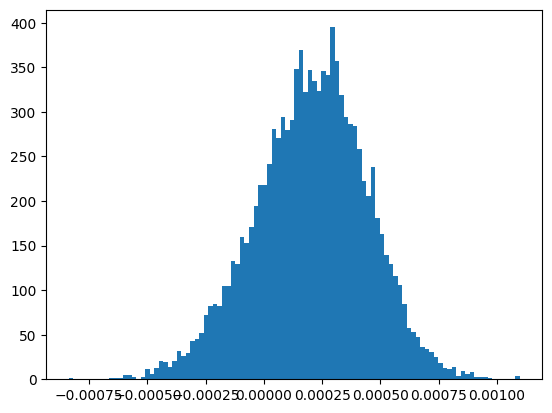

In [42]:
FOS_ko_effect = results_fos_ko_torch - results_control_torch

average_FOS_ko_effect = FOS_ko_effect.mean(axis=0)

plt.hist(average_FOS_ko_effect, bins=100);

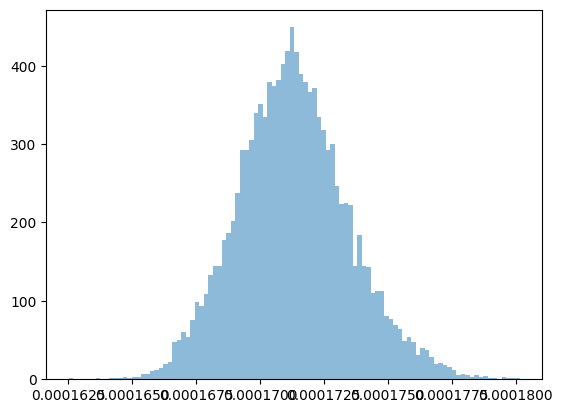

In [51]:
plt.hist(probs_stat2_ko[:,3].detach().cpu().numpy(), bins=100, alpha=0.5, label="STAT2 KO");

In [56]:
control_adata.var['gene_symbols'].to_list().index("ISG15"), control_adata.var['gene_symbols'].to_list().index("STAT2") 

(3, 6760)

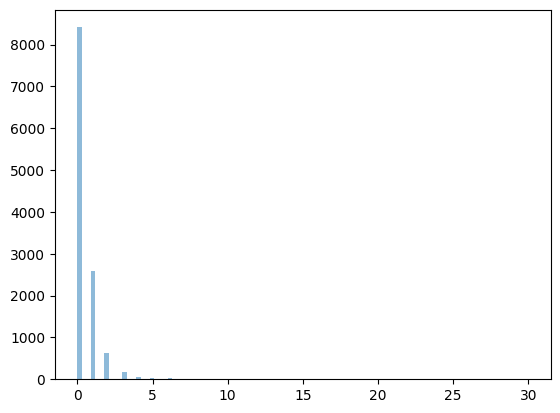

In [72]:
# isg15_counts = control_adata.X[:,[3,6760]].toarray()[:0]
# stat2_counts = control_adata.X[:,[3,6760]].toarray()[:1]

plt.hist(control_adata.X[:,[3,6760]].toarray()[:,0], bins=100, alpha=0.5, label="ISG15");
#plt.hist(stat2_counts, bins=100, alpha=0.5, label="STAT2");


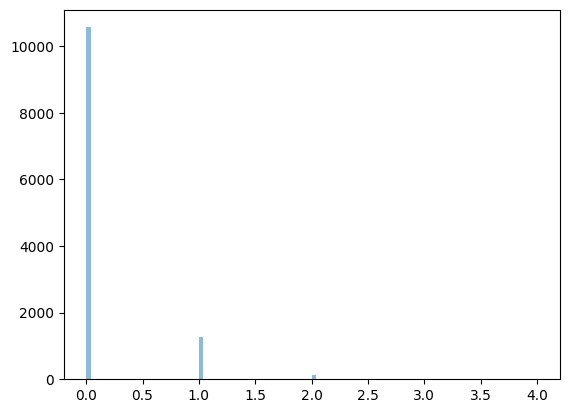

In [73]:
plt.hist(control_adata.X[:,[3,6760]].toarray()[:,1], bins=100, alpha=0.5, label="ISG15");
